<a href="https://colab.research.google.com/github/jagatabhay/TSAI/blob/master/S10/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import cv2

In [2]:
from google.colab import files
files.upload()

Saving resnetmodel.py to resnetmodel.py


{'resnetmodel.py': b'import torch\r\nimport torch.nn as nn\r\nimport torch.nn.functional as F\r\n\r\n\r\nclass BasicBlock(nn.Module):\r\n    expansion = 1\r\n\r\n    def __init__(self, in_planes, planes, stride=1):\r\n        super(BasicBlock, self).__init__()\r\n        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)\r\n        self.bn1 = nn.BatchNorm2d(planes)\r\n        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)\r\n        self.bn2 = nn.BatchNorm2d(planes)\r\n        self.shortcut = nn.Sequential()\r\n        if stride != 1 or in_planes != self.expansion*planes:\r\n            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, self.expansion*planes,kernel_size=1, stride=stride, bias=False),\r\n                                          nn.BatchNorm2d(self.expansion*planes)\r\n                                          )\r\n\r\n    def forward(self, x):\r\n        out = F.relu(self.bn1(self.conv1(

In [0]:
from resnetmodel import *

In [0]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

trans = transforms.Compose([ transforms.ToTensor(),
                             transforms.Normalize(mean, std)
                            ])

In [7]:
from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, VerticalFlip, Resize,Rotate , Cutout
from albumentations.pytorch import ToTensor
import numpy as np

class train_transforms():

    def __init__(self):
        self.albTrainTransforms = Compose([  # Resize(256, 256),
            Rotate((-10.0, 10.0)),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Cutout(num_holes = 8, max_h_size = 8, max_w_size = 8),
            Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ToTensor()
        ])# this is train transforms

    print("REQUIRED LIBRARIES LOADED...")

    def __call__(self, img):
        img = np.array(img)
        img = self.albTrainTransforms(image=img)['image']
        return img

REQUIRED LIBRARIES LOADED...


In [4]:
# Load Transform PY File
from google.colab import files
files.upload()

Saving transform.py to transform.py


{'transform.py': b'# -*- coding: utf-8 -*-\n"""transform.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1TqmrjYL4uAax4RlQ5PmpApY20cq2QS_T\n"""\n\nimport torch\nimport torchvision\nimport torchvision.transforms as transforms\nimport torch.nn as nn\nimport torch.nn.functional as F\n\nmean = (0.4914, 0.4822, 0.4465)\nstd = (0.2023, 0.1994, 0.2010)\n\ntrans = transforms.Compose([ transforms.ToTensor(),\n                             transforms.Normalize(mean, std)\n                            ])\n\nfrom albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, VerticalFlip, Resize,Rotate , Cutout\nfrom albumentations.pytorch import ToTensor\nimport numpy as np\n\nclass train_transforms():\n\n    def __init__(self):\n        self.albTrainTransforms = Compose([  # Resize(256, 256),\n            Rotate((-10.0, 10.0)),\n            HorizontalFlip(p=0.5),\n            VerticalFlip(p=0.5),\n            Cuto

In [5]:
from transform import *

REQUIRED LIBRARIES LOADED...


In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=train_transforms() )
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=30,
                                          shuffle=True,
                                          num_workers=4, 
                                          pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=trans)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=30,
                                         shuffle=False, 
                                         num_workers=4, 
                                         pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 bird plane  ship truck


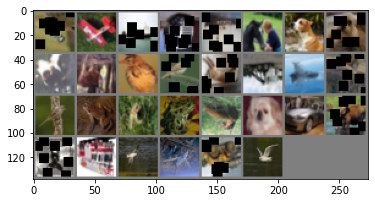

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = next(iter(trainloader))
images, labels = dataiter

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

net = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay=0.001)

schedular= ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=False, 
                             threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

cuda


In [9]:
test = []
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 900 == 899:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 899))
            running_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
              images , labes = data[0].to(device),data[1].to(device)
              outputs = net(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
              test.append(100 * correct / total)
              #print("Accuracy : ", 100 * correct / total)


print('Finished Training')

[1,   900] loss: 1.775
[2,   900] loss: 1.356
[3,   900] loss: 1.150
[4,   900] loss: 1.037
[5,   900] loss: 0.927
[6,   900] loss: 0.856
[7,   900] loss: 0.803
[8,   900] loss: 0.749
[9,   900] loss: 0.723
[10,   900] loss: 0.694
[11,   900] loss: 0.649
[12,   900] loss: 0.630
[13,   900] loss: 0.611
[14,   900] loss: 0.580
[15,   900] loss: 0.545
[16,   900] loss: 0.546
[17,   900] loss: 0.524
[18,   900] loss: 0.510
[19,   900] loss: 0.504
[20,   900] loss: 0.484
[21,   900] loss: 0.468
[22,   900] loss: 0.456
[23,   900] loss: 0.460
[24,   900] loss: 0.437
[25,   900] loss: 0.431
[26,   900] loss: 0.414
[27,   900] loss: 0.408
[28,   900] loss: 0.391
[29,   900] loss: 0.384
[30,   900] loss: 0.390
[31,   900] loss: 0.378
[32,   900] loss: 0.367
[33,   900] loss: 0.362
[34,   900] loss: 0.356
[35,   900] loss: 0.345
[36,   900] loss: 0.344
[37,   900] loss: 0.329
[38,   900] loss: 0.329
[39,   900] loss: 0.327
[40,   900] loss: 0.319
[41,   900] loss: 0.312
[42,   900] loss: 0.306
[

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


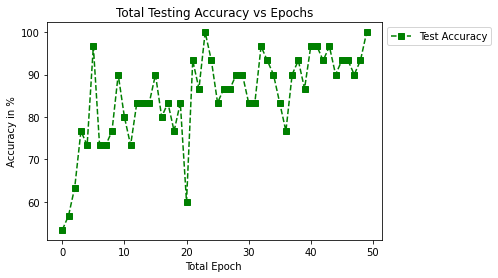

In [11]:
plt.plot(test, marker = 's' , ls = '--' , color='Green' , label='Test Accuracy')
plt.title('Total Testing Accuracy vs Epochs')
plt.xlabel('Total Epoch ')
plt.ylabel(' Accuracy in % ')
plt.legend(loc = 'upper left' , bbox_to_anchor = (1,1))
plt.show()

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

model_save_name = 'S10_Assignment_Model.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(net.state_dict(), path)
print("Saving Complete")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Saving Complete
